In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/home/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [183]:
import importlib
importlib.reload(energy_models)

<module 'energy_models' from '/home/scrotti/Aptamer2025py/energy_models.py'>

In [190]:
L, q = 3, 2

h = torch.randn(L, q)
J_ = torch.randn(L*q, L*q)
J_ = J_ + J_.t()
J = J_.reshape(L, q, L, q)

potts = energy_models.Potts(J, h)

In [191]:
M = 5
x_ = torch.randint(q, (M, L))
x = one_hot(x_)

In [192]:
en = potts.compute_energy(x)
potts_zerosum = potts.set_zerosum_gauge()
en_zerosum = potts_zerosum.compute_energy(x)
en - en_zerosum

tensor([4.3903, 4.3903, 4.3903, 4.3903, 4.3903], grad_fn=<SubBackward0>)

In [193]:
potts_zerosum.h

Parameter containing:
tensor([[-0.5751,  0.5751],
        [ 1.0849, -1.0849],
        [ 2.6169, -2.6169]], requires_grad=True)

In [194]:
params = {'bias': potts.h, 'coupling_matrix': potts.J}
params_zerosum = adabmDCA.dca.set_zerosum_gauge(params)

en_adabm = adabmDCA.statmech.compute_energy(x, params)
en_adabm_zerosum = adabmDCA.statmech.compute_energy(x, params_zerosum)
en_adabm - en_adabm_zerosum

tensor([3.9745, 4.2243, 0.0563, 4.2587, 3.9745], grad_fn=<SubBackward0>)

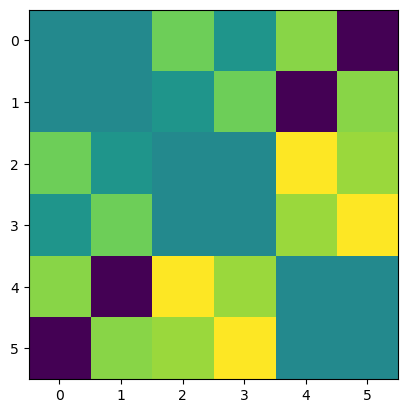

In [195]:
plt.imshow(potts_zerosum.J.reshape(L*q, L*q).detach().numpy())

In [167]:
torch.allclose(
    potts.J,
    potts.J.transpose(0,2).transpose(1,3)
)

True

In [168]:
torch.allclose(
    potts_zerosum.J,
    potts_zerosum.J.transpose(0,2).transpose(1,3)
)

True